In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import seaborn as sns
import helper
import os
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

In [12]:
exp_measures = pd.read_csv("../data/measures.csv")
exp_data = pd.read_csv("../data/processed_data.csv", index_col=["subj_id", "session", "route", "intersection_no"])
model_params = pd.read_csv("../model_fit_results/model_1/best_fit_parameters/full_data_parameters_fitted.csv")
simulation_results_path = "../model_fit_results/model_1/simulation_results/"

# Main paper figures

### Model diagram

In [3]:
def get_trace(t, dt, tta, d, model_params):  
    noise = np.random.randn(len(t))
    drift = model_params["alpha"]*(tta+ model_params["beta"]*d - model_params["theta"])
    dx = drift * simulation_params["dt"] +  model_params["noise"] * noise * np.sqrt(simulation_params["dt"])
    x = np.append([0], np.cumsum(dx)[:-1])    
    boundary = model_params["b_0"]/(1+np.exp(-model_params["k"]*(tta-model_params["tta_crit"])))
    response_time_idx = np.where(abs(x)>boundary)
    if len(response_time_idx[0])>0:
        return(x[:response_time_idx[0][0]+1])
    else:
        return(x)
    
def generate_model_traces(t, dt, tta, d, model_params):
    is_two_correct = False
    is_rt_ok = False
    while not(is_two_correct) or not(is_rt_ok):
        trials = [get_trace(t, dt, tta, d, model_params) for i in range(3)]
        is_two_correct = (np.sum([1 if x[-1]>0 else 0 for x in trials]) == 2)
        rts = [model_params["ndt_location"]+len(trial)*dt for trial in trials]
        is_rt_ok = all([(rt>0.4) & (rt<0.7) for rt in rts])
    pd.DataFrame(trials).to_csv("ddm_traces.csv")

In [4]:
def plot_model_traces(model_params, simulation_params, generate_new=False):
    colors = {"go": "#4052ac", "stay": "#e6263d", "equation": "#50596A"}
    condition = {"tta": 6, "d": 120}
    dt = simulation_params["dt"]
    t = np.arange(0, simulation_params["duration"], dt)
    d = condition["d"] - (condition["d"] / condition["tta"])*t
    tta = condition["tta"] - t
    ndt = model_params["ndt_location"]

    if generate_new:
        generate_model_traces(t, dt, tta, d, model_params)        
    trials = [x[1][~x[1].isna()].values[1:] for x in pd.read_csv("ddm_traces.csv").iterrows()]
    
    fig, (ax_rate, ax) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={"height_ratios": [1, 3]}, dpi=150, sharex=True)
    
    for x in trials:
        color = colors["go"] if x[-1]>0 else colors["stay"]
        ax.plot(t[:len(x)]+ndt, x, lw=1.0, alpha=0.4, color=color)
        ax.plot(t[len(x)]+ndt, x[-1], ls="", alpha=0.8, marker="o", ms=4, color=color)

    for tta_condition in [4, 6]:
        boundary = model_params["b_0"]/(1+np.exp(-model_params["k"]*(tta_condition-t-model_params["tta_crit"])))
        ax.plot(t+ndt, boundary, ls="--", color="gray", alpha=0.6)
        ax.plot(t+ndt, -boundary, ls="--", color="gray", alpha=0.6)
        ax.text(0.78, 0.3+0.15*(tta_condition-4), r"TTA$|_{t=0}$=%is" % (tta_condition),
                color=colors["equation"], alpha=0.6, fontsize=16)
        
        # Add extra markers to illustrate what would happen if the boundary was lower (TTA condition is 4s)
        if tta_condition==4:
            for x in trials:
                color = colors["go"] if x[-1]>0 else colors["stay"]
                response_time_idx = np.where(abs(x)>boundary[:len(x)])[0][0]
                ax.plot(t[response_time_idx]+ndt, x[response_time_idx], ls="", alpha=0.5,
                        marker="o", ms=4, color=color)

    ax.text(0.01, 0.04, "Non-decision time", color=colors["equation"], fontsize=13)
    ax.plot([0, ndt], [0,0], lw=1, color=colors["equation"])
    ax.vlines(x=[0, ndt-0.002], ymin=-0.02, ymax=0.09, ls="--", color=colors["equation"], lw=1)

    ax.annotate("", xy=(ndt,0), xytext=(ndt+0.2, 0.15),
                 arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color=colors["equation"], linewidth=2))
    ax.text(0.43, 0.02, r"$dx = \alpha(TTA + \beta d - \theta_{crit}) dt + dW$", color=colors["equation"], fontsize=16)
    
    ax.text(0.47, 0.6, "Go", color=colors["go"], alpha=0.7, fontsize=16)
    ax.text(0.47, -0.65, "Stay", color=colors["stay"], alpha=0.7, fontsize=16)

    ax.set_xlabel(r"Time $t$", fontsize=14)
    ax.set_ylabel(r"Accumulated evidence $x$", fontsize=14)
    ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
    ax.set_ylim((-0.7, 0.7))
   
    ax_rate.plot(t+ndt, tta+model_params["beta"]*d, color="#50596A", alpha=0.8)
    ax_rate.axhline(model_params["theta"], color="grey", alpha=0.6, ls="--", xmin=0.01, xmax=0.99)
    ax_rate.set_ylabel(r"$TTA + \beta d$", fontsize=16)
    ax_rate.set_xlim((0,1))
    ax_rate.set_ylim((8,12))
    ax_rate.text(0.05, 9.5, r"$\theta_{crit}$", color="grey", alpha=0.7, fontsize=16)

    sns.despine(offset=2, trim=True)
    plt.tight_layout()

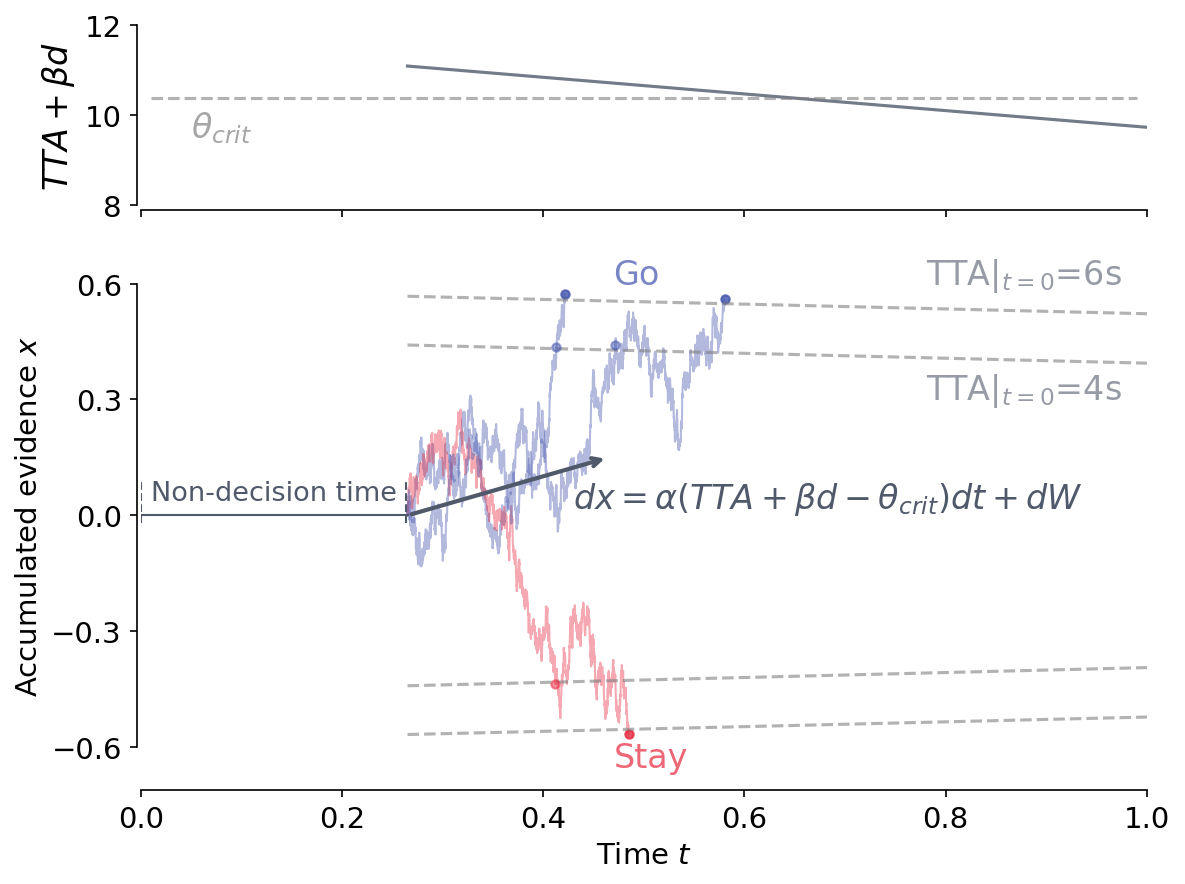

In [5]:
all_subj_params = model_params[model_params.subj_id=="all"].to_dict("records")[0]
all_subj_params["ndt_location"] -= 0.1
all_subj_params["theta"] += 0.5
simulation_params = {"dt": 0.0001, "duration": 1}

plot_model_traces(all_subj_params, simulation_params, generate_new=False)
plt.savefig("../output/fig_model_diagram.png", bbox_inches="tight")

### Trial timeline

In [6]:
traj_id = (129, 1, 2, 5)
traj = exp_data.loc[traj_id].reset_index()

In [7]:
def plot_traj(traj, ax=None):
    color = "#50596A"
    font_size = 14
    ms = 12
    lw = 3
    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    traj.loc[:, "t"] -= traj.t.values[idx_bot_spawn]
    
    fig, axes = plt.subplots(4, 1, figsize=(8,6), dpi=150, sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color=color, lw=lw)
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color=color, ls="", marker="o", ms=ms)
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color=color, ls="", marker="x", ms=ms)
    axes[0].set_ylabel("Velocity, m/s", fontsize=font_size)
    axes[0].set_ylim((-1, 7))
    
    for x in [traj.t[idx_bot_spawn], traj.t[idx_response]]:
        axes[0].axvline(x=x, ymin=-0.3, ymax=0.5, c=color, ls="--", clip_on=False)
        axes[1].axvline(x=x, ymin=-0.2, ymax=1, c=color, ls="--", clip_on=False)
    
    axes[1].annotate(text="", xy=(traj.t[idx_bot_spawn], 70), xytext=(traj.t[idx_response], 70),
                     arrowprops=dict(arrowstyle="<->", color="0.5"))
    axes[1].text(.21, .79, "Response time (RT)", transform=axes[1].transAxes, fontsize=font_size)
    
#     throttle_brake = traj.throttle-traj.brake
    axes[1].plot(traj.t, 100*traj.throttle, color=color, lw=lw)
    axes[1].plot(traj.t[idx_bot_spawn], 100*traj.throttle[idx_bot_spawn], color=color, ls="", marker="o", ms=ms)
    axes[1].plot(traj.t[idx_response], 100*traj.throttle[idx_response], color=color, ls="", marker="x", ms=ms)
    axes[1].set_ylabel("Gas pedal, %", fontsize=font_size)
    axes[1].set_ylim((-20, 120))
    axes[1].set_yticks([0, 100])

    axes[2].plot(traj.t[idx_bot_spawn:], traj.d_ego_bot[idx_bot_spawn:], color=color, lw=lw)
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color=color, ls="", marker="o", ms=ms)
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color=color, ls="", marker="x", ms=ms)
    axes[2].set_ylabel("Distance, m", fontsize=font_size)
    axes[2].set_ylim((80, 122))

    axes[3].plot(traj.t[idx_bot_spawn:], traj.tta[idx_bot_spawn:], color=color, lw=lw)
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color=color, ls="", marker="o",
                 label="Velocity$=0$: oncoming car appears", ms=ms)
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color=color, ls="", marker="x",
                 label="Gas pedal$>0$: decision is made", ms=ms)
    axes[3].set_ylabel("TTA, s", fontsize=font_size)
    axes[3].set_ylim((3.5, 6.5))
    axes[3].set_yticks([4, 5, 6])

    axes[3].set_xlim((-0.3, 1.5))
    axes[3].set_xticks(np.arange(0, 1.4, 0.3))
    
    axes[3].set_xlabel("Time $t$, s", fontsize=font_size)

    legend = fig.legend(loc="upper left", fontsize=font_size, bbox_to_anchor=(0.4, 1.05), frameon=False)
#     legend.get_title().set_fontsize("16")
    plt.tight_layout()

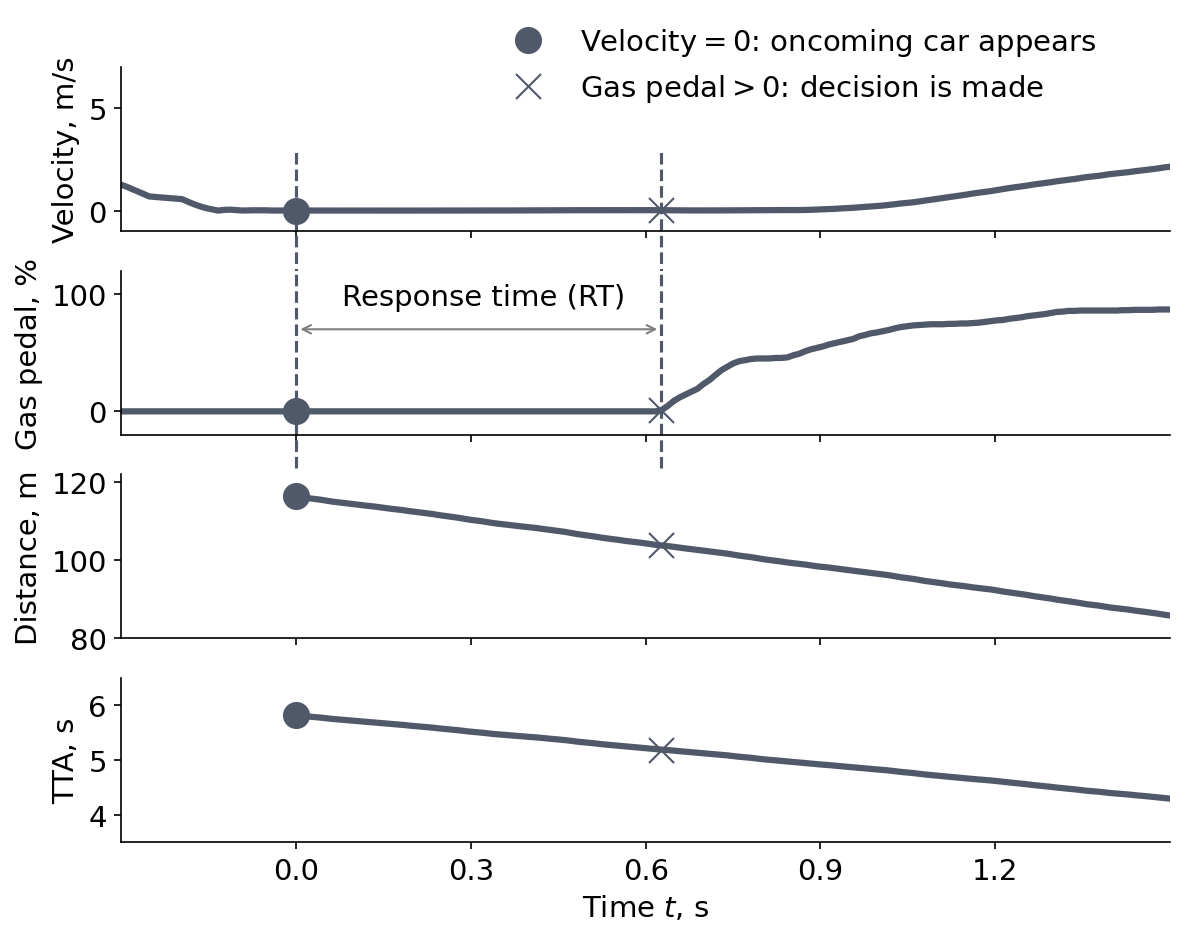

In [8]:
plot_traj(traj)
plt.savefig("../output/fig_trial_timeline.png", bbox_inches="tight")

### Model fit against data

In [9]:
def plot_all_subj_p_go(ax, exp_data, d_condition, marker, color, marker_offset=0):
    between_subj_mean = exp_data[(exp_data.d_condition==d_condition)].groupby(["subj_id", "tta_condition"]).mean()
    data_subj_d_measures = helper.get_mean_sem(between_subj_mean.reset_index(), var="is_go_decision", n_cutoff=2)
    ax.errorbar(data_subj_d_measures.index+marker_offset, data_subj_d_measures["mean"], yerr=data_subj_d_measures["sem"],
                    ls="", marker=marker, ms=9, color=color)
    
def plot_subj_p_go(ax, exp_data, d_condition, subj_id, marker, color):
    data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]
    psf_ci = helper.get_psf_ci(data_subj_d_measures)
    ax.plot(psf_ci.tta_condition, psf_ci.p_go, ls="", marker=marker, ms=9, color=color, zorder=10)
    ax.vlines(x=psf_ci.tta_condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)

def plot_subj_rt(ax, exp_data, d_condition, subj_id, marker, color, marker_offset=0):
    if subj_id=="all":
        between_subj_mean = exp_data[(exp_data.d_condition==d_condition) & (exp_data.is_go_decision)].groupby(["subj_id", "tta_condition"]).mean()
        measures = between_subj_mean.reset_index()
    else:
        measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition) & (exp_data.is_go_decision)]

    if len(measures)>0:
        measures_mean_sem = helper.get_mean_sem(measures, var="RT", n_cutoff=2)
        ax.errorbar(measures_mean_sem.index+marker_offset, measures_mean_sem["mean"], yerr=measures_mean_sem["sem"],
                        ls="", marker=marker, ms=9, color=color)
    
def plot_compare_model_exp(var, exp_data, model_measures, ylabel):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({"subj_id": str})
    # group_rt_means = pd.read_csv("rt_group_means.csv")
    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    markers=["o", "s", "^"]
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    
    subjects = model_measures.subj_id.unique()
    
    fig, axes = plt.subplots(4, 5, figsize=(14,12), sharex=True, sharey=True)

    axes_to_plot = np.concatenate([axes[:,:4].flatten(), [axes[0,4]]])
    for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes_to_plot):
        ax.set_title("All participants" if subj_id=="all" else "P%s" % (subj_idx+1), fontsize=16)
        for d_condition, color, marker in zip(d_conditions, colors, markers):
            model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                                   & (model_measures.d_condition==d_condition)]         
            
            if var=="is_go_decision":
                # Model
                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], 
                    color=color, label=d_condition)
                
                # Data
                # for all subjects, use scipy sem estimates, since we average over continuous measures (p_go)
                if subj_id=="all":
                    plot_all_subj_p_go(ax, exp_data, d_condition, marker, color)
                # for individual subjects, use binomial proportion sem estimates, since we average over binary measures (p_go)
                else:
                    plot_subj_p_go(ax, exp_data, d_condition, subj_id, marker, color)

            elif var=="RT":
                # Model
                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], color=color, label=d_condition)

                # Data
                plot_subj_rt(ax, exp_data, d_condition, subj_id, marker, color)
                
                # ax.set_xticklabels([4, 5, 6])
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])
            else:
                raise(ValueError)

        ax.legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")

    sns.despine(offset=5, trim=True)

    for ax in axes[1:,4]:
        fig.delaxes(ax)

    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0, label="Data, d=%im" % (d_condition))
                       for d_condition, color, marker in zip(d_conditions, colors, markers)] 
                       + [Line2D([0], [0], color="grey", label="Model")])

    fig.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0.9, 0.62), fontsize=16, frameon=False)

    fig.text(0.35, -0.02, "Time-to-arrival (TTA), s", fontsize=18)
    fig.text(-0.02, 0.39, ylabel, fontsize=18, rotation=90)

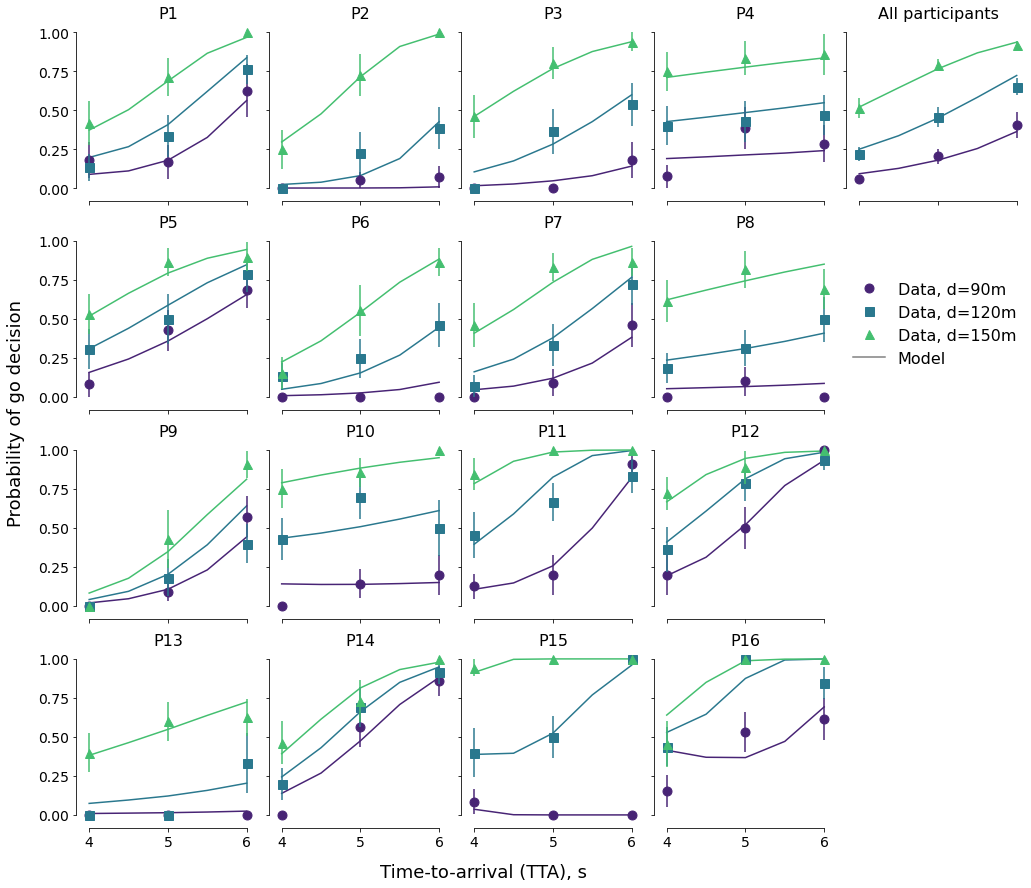

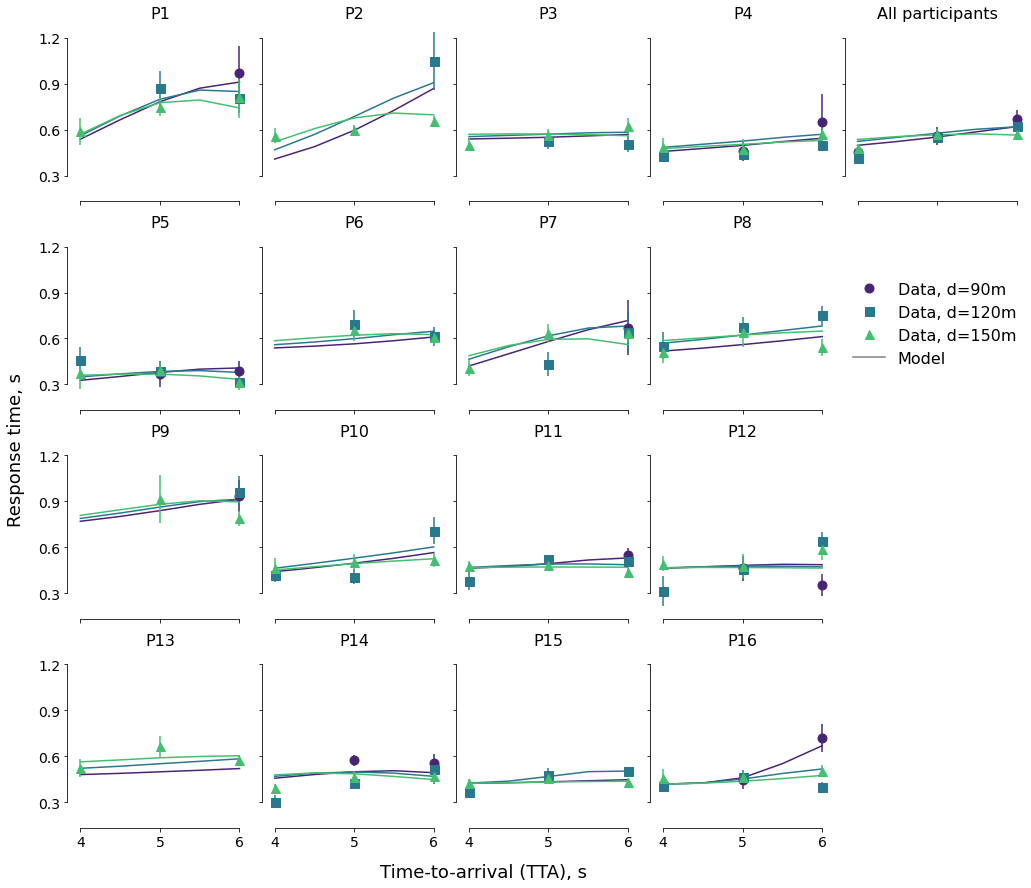

In [10]:
model_measures_all_conditions = pd.read_csv(os.path.join(simulation_results_path, "full_data_measures.csv"))

plot_compare_model_exp("is_go_decision", exp_measures, model_measures_all_conditions, "Probability of go decision")
plt.savefig("../output/fig_p_go.png", bbox_inches="tight")

plot_compare_model_exp("RT", exp_measures, model_measures_all_conditions, "Response time, s")
plt.savefig("../output/fig_RT.png", bbox_inches="tight")

### RT distributions

In [13]:
def plot_condition_vincentized_dist(ax, condition, condition_data, kind="cdf"):
    # colors = dict(zip([90,120,150], [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,3)]))
    # markers={90: "o", 120: "s", 150: "^"}
#     q = [0.1, 0.3, 0.5, 0.7, 0.9]
    q = np.linspace(0.01, 0.99, 15)
    condition_quantiles = condition_data.groupby("subj_id").apply(lambda d: np.quantile(a=d.RT, q=q)).mean()

    rt_range = np.linspace(condition_quantiles.min(), condition_quantiles.max(), len(q))
    step = rt_range[1] - rt_range[0]
    rt_grid = np.concatenate([rt_range[:3]-3*step, rt_range, rt_range[-3:]+step*3])
    vincentized_cdf = np.interp(rt_grid, condition_quantiles, q, left=0, right=1)
    vincentized_pdf = helper.differentiate(rt_grid, vincentized_cdf)

    ax.plot(rt_grid, vincentized_cdf, label="Data", color="grey", ls="", ms=9, marker="o")
    ax.set_ylim([-0.05, 1.1])
    ax.set_yticks([0.0, 0.5, 1.0])

def decorate_axis(ax, condition):
    if (((condition["d"] == 90) & (condition["TTA"] == 6))
        | ((condition["d"] == 90) & (condition["TTA"] == 5))
        | ((condition["d"] == 120) & (condition["TTA"] == 4))):
        ax.text(0.5, 1.02, "TTA=%is" % condition["TTA"], fontsize=16, transform=ax.transAxes,
                    horizontalalignment="center", verticalalignment="center")

    if condition["TTA"] == 6:
        ax.text(1.0, 0.5, "d=%im" % condition["d"], fontsize=16, transform=ax.transAxes, rotation=-90,
            horizontalalignment="center", verticalalignment="center")
    
def plot_vincentized_dist(fig, axes, exp_data, model_rts, model_no):
    plot_data = True if model_no == 1 else False
    conditions = [{"d": d, "TTA": TTA}
                  for d in sorted(exp_data.d_condition.unique()) 
                  for TTA in sorted(exp_data.tta_condition.unique())]
    
    for (ax, condition) in zip(axes.flatten(), conditions):
        condition_data = exp_data[(exp_data.is_go_decision)
                            & (exp_data.d_condition==condition["d"])
                            & (exp_data.tta_condition==condition["TTA"])]
        if len(condition_data) >= 25:       
            # Group-averaged data
            if plot_data:
                plot_condition_vincentized_dist(ax, condition, condition_data)
            
            # Model
            if not model_rts is None:
                condition_rts = model_rts[(model_rts.subj_id=="all")
                                        & (model_rts.d_condition==condition["d"])
                                        & (model_rts.tta_condition==condition["TTA"])]
                ax.plot(condition_rts.t, condition_rts.rt_corr_distr, color="black", alpha=0.8, lw=2)#, color="C%i" % (model_no-1))
        else:
            ax.set_axis_off()

        if plot_data:
            decorate_axis(ax, condition)

            ax.set_xlabel("")
            ax.set_xlim((0, 1.5))
            sns.despine(offset=5, trim=True)

    # if plot_data:
    #     legend_elements = ([Line2D([0], [0], color="grey", marker="*", ms=9, lw=0, label="Group-averaged data")]
    #     + [Line2D([0], [0], color="C%i" % (model_no-1), label="Model %i" % model_no) for model_no in [1,2,3]])
    #     fig.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0.25, 0.75), fontsize=16, frameon=True)
    legend_elements = ([Line2D([0], [0], color="grey", marker="o", ms=9, lw=0, label="Group-averaged data"),
                        Line2D([0], [0], color="grey", label="Model")])
    fig.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0.2, 0.75), fontsize=16, frameon=True)

    fig.text(0.43, 0.04, "Response time, s", fontsize=16)
    fig.text(0.04, 0.15, "Cumulative distribution function", fontsize=16, rotation=90)
    
    return fig, axes

E:\source\evidence_accumulation_in_gap_acceptance\venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


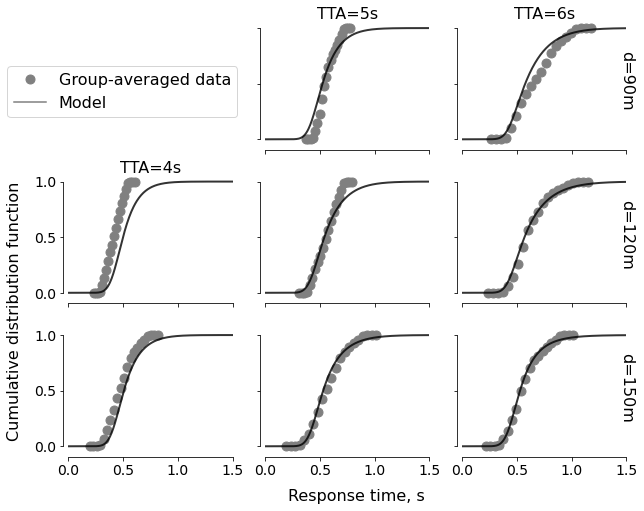

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)

model_rts = pd.read_csv(os.path.join(simulation_results_path, "full_data_rt_cdf.csv"))
plot_vincentized_dist(fig, axes, exp_measures, model_rts, model_no=1)
# fig.suptitle("Model %i" % model_no)
plt.savefig("../output/fig_RT_dist.png", bbox_inches="tight")

### Model cross-validation

In [15]:
model_measures_cross_validation_8 = pd.read_csv(os.path.join(simulation_results_path, "cross_validation_8_measures.csv"))

In [16]:
def plot_cross_validation_per_subj(exp_data, model_measures, subj_id):
    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    markers=["o", "s", "^"]
    marker_size=9
    marker_offset = 0.05
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    
    if not subj_id=="all":
        fig.suptitle("P%s" % (subj_id), fontsize=16)
    
    for d_condition, marker, color in zip(d_conditions, markers, colors):
        model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                               & (model_measures.d_condition==d_condition)]
        # Model
        ax1.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures["is_go_decision"],
                    color=color, label=d_condition, ls="--", lw=1, marker=marker, ms=marker_size, fillstyle="none")
        ax2.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures["RT"],
                color=color, label=d_condition, ls="--", lw=1, marker=marker, ms=marker_size, fillstyle="none")

        # Data
        plot_all_subj_p_go(ax1, exp_data, d_condition, marker, color, -marker_offset)
        plot_subj_rt(ax2, exp_data, d_condition, subj_id, marker, color, -marker_offset)

    fig.text(0.35, -0.05, "Time-to-arrival (TTA), s", fontsize=16)
    
    ax1.set_xticks([4, 5, 6])
    ax2.set_xticks([4, 5, 6])
    
    ax1.legend().remove()
    ax2.legend().remove()
    
    ax1.set_ylabel("Probability of go", fontsize=16)
    ax2.set_ylabel("Response time", fontsize=16)

    ax1.set_ylim((0.0, 1.0))
    ax2.set_ylim((0.3, 0.8))
    
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=1, ls="--", fillstyle="none", label="Model predictions,")
                           for d_condition, marker, color in zip(d_conditions, markers, colors)] 
                       + [Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=0, label="data, d=%im" % (d_condition))
                           for d_condition, marker, color in zip(d_conditions, markers, colors)])

    fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=16, handlelength=1.5, columnspacing=0.2,
               frameon=False, ncol=2)

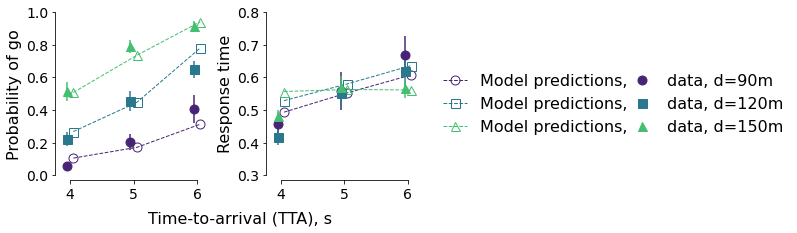

In [17]:
plot_cross_validation_per_subj(exp_measures, model_measures_cross_validation_8, subj_id="all")
plt.savefig("../output/fig_cross_validation_8_vincent.png", bbox_inches="tight")

#  Supplementary figures

- Fitted parameters per participant
- Uncertainty estimates for fitted parameters
- Compare models using the same plots as in the main paper
-- p_go
-- RT
-- RT distributions
- Compare models using predictive metrics
-- ROC of p_go per participant
-- R-squared of RT per participant
-- ROC and R-squared for cross-validation


## Fitted parameter values

In [184]:
def plot_fitted_params(model_params):
    fig, axes = plt.subplots(1, 8, dpi=100, figsize=(8,3))
    params_to_plot = model_params.drop(columns=["tta_condition", "d_condition", "loss"]).set_index("subj_id")
    param_display_names = ["$\\alpha$", "$\\beta$", "$\\theta_{crit}$", "$b_0$", "$k$", "$\\tau$", "$\\mu_{ND}$", "$\\sigma_{ND}$"]

    for param_name, display_name, ax in zip(params_to_plot.columns, param_display_names, axes.flatten()):
        param_values = params_to_plot.loc[~(params_to_plot.index.get_level_values(level="subj_id")=="all"), param_name]
        sns.stripplot(ax=ax, data=param_values, color="C0")
        sns.stripplot(ax=ax, data=[params_to_plot.loc["all", param_name]], marker='s', size=6, color="C1")
        sns.boxplot(ax=ax, data=param_values, whis=[0, 100], linewidth=0.5, boxprops=dict(alpha=.1))
        ax.set_xlabel(display_name)
        ax.get_xaxis().set_ticks([])
        ax.spines['left'].set_alpha(0.3)

    legend_elements = ([Line2D([0], [0], color="C0", marker='o', ms=4, ls="", label="inividual participants"),
                        Line2D([0], [0], color="C1", marker='s', ms=6, ls="", label="all participants")])
    legend = fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.99, 0.5), fontsize=14, frameon=False)
    legend.set_title("Model fitted to", prop={'size':16})

    sns.despine(bottom=True, offset=2)
    fig.text(-0.02, 0.2, "Parameter value", fontsize=16, rotation=90)

    plt.tight_layout()

    params_to_export = params_to_plot.reset_index()
    params_to_export.columns = ["Participant", "$\\alpha$", "$\\beta$", "$\theta_{\textrm{crit}}$", "$b_0$",
                                "$k$", "$\tau$", "$\mu_{\textrm{ND}}$", "$\sigma_{\textrm{ND}}$"]
    params_to_export["Participant"] = range(len(params_to_export))
    params_to_export["Participant"] += 1
    params_to_export.iloc[-1, 0] = "all"

    with open("../output/tab_SI_params.tex", "w") as tf:
        tf.write(params_to_export.to_latex(float_format="%.2f", escape=False, index=False))

    return params_to_export

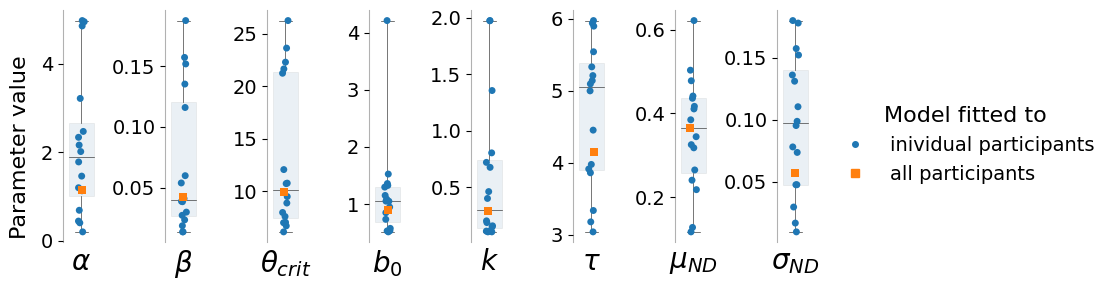

In [185]:
params_to_export = plot_fitted_params(model_params)
plt.savefig("../output/fig_SI_params.png", bbox_inches="tight")

In [186]:
params_to_export

,Participant,$\alpha$,$\beta$,$\theta_{\textrm{crit}}$,$b_0$,$k$,$\tau$,$\mu_{\textrm{ND}}$,$\sigma_{\textrm{ND}}$
0,1,1.465101,0.018664,6.680473,1.358825,1.356360,3.860662,0.264850,0.047674
1,2,2.166484,0.038774,9.472298,4.212950,0.719124,5.941149,0.240345,0.009653
2,3,2.474682,0.053874,12.043280,0.529389,0.107809,4.999867,0.503477,0.136171
3,4,0.205143,0.187549,26.239770,1.150890,0.156334,4.453769,0.217725,0.016763
4,5,1.133518,0.027239,7.574977,1.051087,0.102798,3.976779,0.127398,0.073737
5,6,2.019625,0.041021,10.751197,0.848347,0.200491,5.333476,0.478199,0.110586
6,7,1.202551,0.029875,7.956272,1.325787,0.803443,3.336020,0.116699,0.047683
7,8,0.409683,0.135284,21.634810,1.296452,0.184983,5.142172,0.325358,0.178058
8,9,1.785406,0.013604,6.981798,1.085588,0.109460,3.038809,0.622211,0.157499
9,10,0.449293,0.151842,22.277862,1.049106,0.399266,5.212551,0.317776,0.095404


## Robustness of fit

In [171]:
model_param_path = "../model_fit_results/model_1/best_fit_parameters/full_data_repeated/"

repeated_fit_params = pd.concat([pd.read_csv(os.path.join(model_param_path, file_name)) for file_name in os.listdir(model_param_path)]).reset_index(drop=True)
repeated_fit_params = repeated_fit_params.drop(columns=["tta_condition", "d_condition", "loss"])
repeated_fit_params.loc[repeated_fit_params.subj_id==969, "subj_id"] = 15
repeated_fit_params.loc[repeated_fit_params.subj_id==996, "subj_id"] = 16
params_to_plot = repeated_fit_params.melt(id_vars=["subj_id", "n"]).rename(columns={"subj_id": "Participant", "variable": "parameter"})

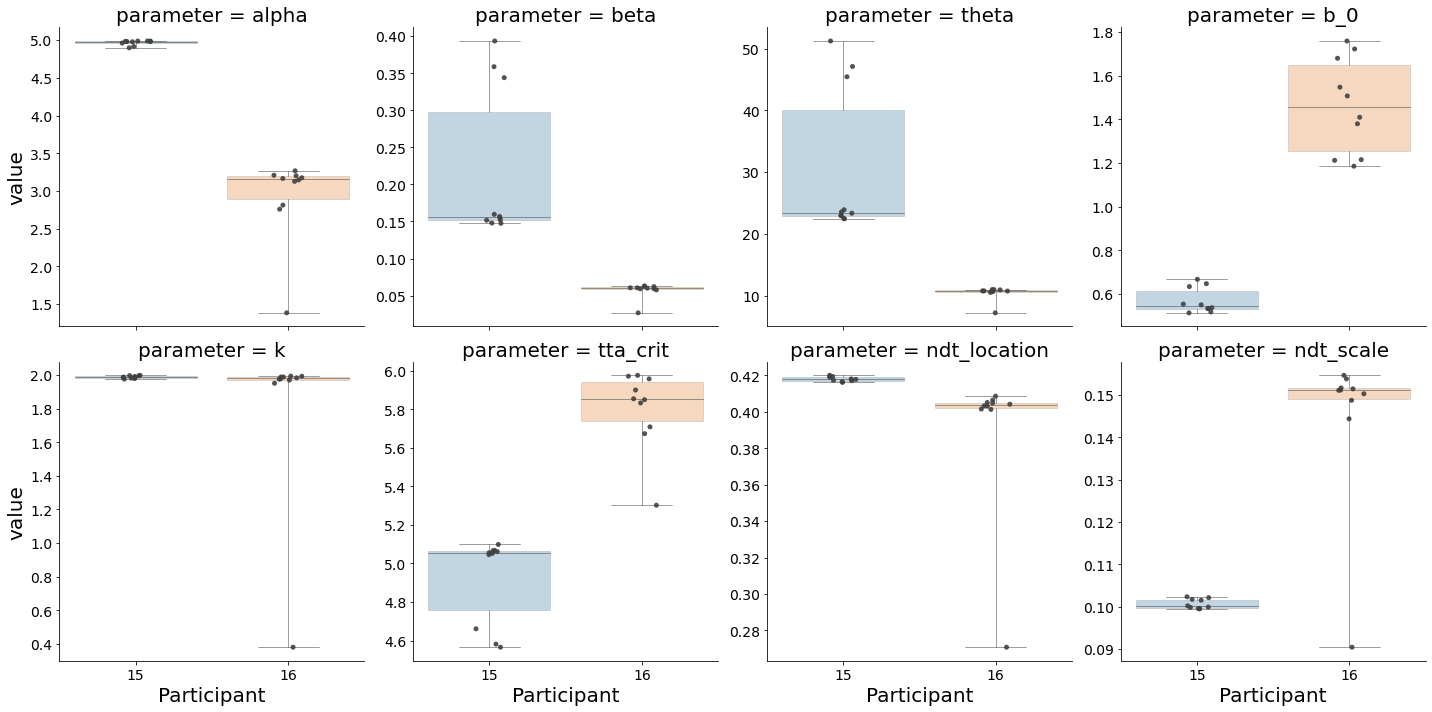

In [177]:
g = sns.catplot(data=params_to_plot, x='Participant', y='value', col='parameter', kind='box', col_wrap=4, sharey=False, whis=[0, 100], linewidth=0.5, boxprops=dict(alpha=.3))
g.map_dataframe(sns.stripplot, x="Participant", y="value", palette=["#404040"], alpha=0.9, dodge=True)

## Predictive metrics

In [3]:
best_fit_params_path = "../model_fit_results/model_%i/best_fit_parameters/%s_parameters_fitted.csv"
fit_results_path = "../model_fit_results/model_%i/simulation_results/%s_measures.csv"

groupby_cols = ["subj_id", "tta_condition", "d_condition"]
subjects = exp_measures.subj_id.unique()

In [4]:
def get_RT_means_with_cutoff(data, groupby_cols, n_cutoff=2):
    mean = data.groupby(groupby_cols)["RT"].mean()
    # sem = data.groupby("tta_condition")[var].apply(lambda x: scipy.stats.sem(x, axis=None, ddof=0))
    n = data.groupby(groupby_cols).size()
    means = pd.DataFrame({"RT": mean, "n": n}, index=mean.index)
    return means[means.n>n_cutoff].RT

In [5]:
def get_data_vs_model_means(data_means, model_no=1, kind="full_data"):
    model_measures = pd.read_csv(fit_results_path % (model_no, kind))
    model_measures = model_measures[model_measures.tta_condition.isin([4, 5, 6])
                                    & model_measures.d_condition.isin([90, 120, 150])]
    if kind=="full_data":
        model_measures = model_measures[~(model_measures.subj_id=="all")]
        model_measures["subj_id"] = pd.to_numeric(model_measures.subj_id)
    # else:
    #     raise(ValueError("kind should be either full_data or cross_validation_8"))

    model_measures.set_index(groupby_cols, inplace=True)

    data_vs_model = data_means.join(model_measures, lsuffix="_data", rsuffix="_model").reset_index()
    data_vs_model = data_vs_model.rename(columns={"is_go_decision_data": "p_go_data",
                                                  "is_go_decision_model": "p_go_model"})
    # data_vs_model["subj_id"] =  data_vs_model["subj_id"].astype(int)
    data_vs_model[["tta_condition", "d_condition"]] = data_vs_model[["tta_condition", "d_condition"]].astype(int)
    data_vs_model["condition"] = data_vs_model[["tta_condition", "d_condition"]].astype(str).agg("_".join, axis=1).astype(str)

    return data_vs_model

In [6]:
p_go_by_condition = exp_measures.groupby(groupby_cols).mean().is_go_decision
rt_by_condition = get_RT_means_with_cutoff(exp_measures[exp_measures.is_go_decision], groupby_cols, n_cutoff=2)
data_means = pd.DataFrame([p_go_by_condition, rt_by_condition]).T

### ROC of predicting probability of go decision per participant

In [7]:
def get_positive_rates(df, threshold):
    df["model_is_go_decision"] = df["p_go_model"]>threshold
    fpr = (len(df[~(df.is_go_decision==df.model_is_go_decision) & (df.model_is_go_decision)])
                   /len(df[~df.is_go_decision]))
    tpr = (len(df[(df.is_go_decision==df.model_is_go_decision) & (df.model_is_go_decision)])
                   /len(df[df.is_go_decision]))

    return (fpr, tpr)

def get_roc_curve(data_means, exp_measures, subj_id, model_no=1, kind="full_data"):
    subj_data_vs_model = exp_measures.loc[exp_measures.subj_id == subj_id,
                                          ["subj_id", "tta_condition", "d_condition", "is_go_decision"]]
    if model_no == "best_case":
        model_predictions = data_means.reset_index().rename(columns={"is_go_decision": "p_go_model"})
    else:
        data_vs_model = get_data_vs_model_means(data_means=data_means, model_no=model_no, kind=kind)
        model_predictions = data_vs_model.loc[data_vs_model.subj_id == subj_id,
                                              ["subj_id", "tta_condition", "d_condition", "p_go_model"]]
    subj_data_vs_model = (subj_data_vs_model.merge(model_predictions, on=["subj_id", "tta_condition", "d_condition"])
                 .reset_index(drop=True))
    roc = np.array([get_positive_rates(subj_data_vs_model, threshold=threshold) for threshold in np.linspace(1.001, -0.001, 21)]).T
    auc = np.trapz(y=roc[1], x=roc[0])
    return roc, auc

Best-case predictors per participant: the best theoretically possible ROC can be obtained from the estimated probabilities. By the way, the nudge-based manipulation of p_turn in the follow-up work could be linked to pushing the limits of theoretically possible prediction - if we cannot really be sure what the human will do and it might affect safety, we better sacrifice the current comfort to increase our prediction accuracy

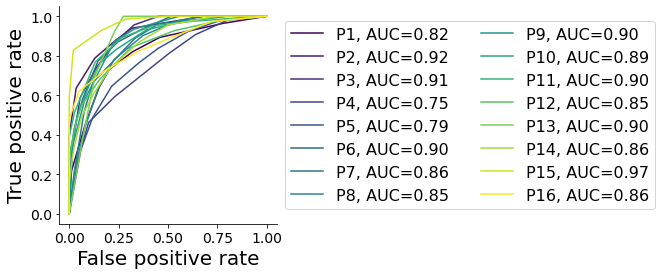

In [8]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('viridis', 16)
for subj_id, subj_idx in zip(exp_measures.subj_id.unique(), range(len(subjects))):
    roc, auc = get_roc_curve(data_means, exp_measures, subj_id, model_no="best_case")
    ax.plot(roc[0], roc[1], label="P%i, AUC=%.2f" % (subj_idx+1, auc), color=cmap(subj_idx))
    ax.set_aspect("equal")
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)
ax.set_aspect("equal")

Comparing models by their ROC per participant

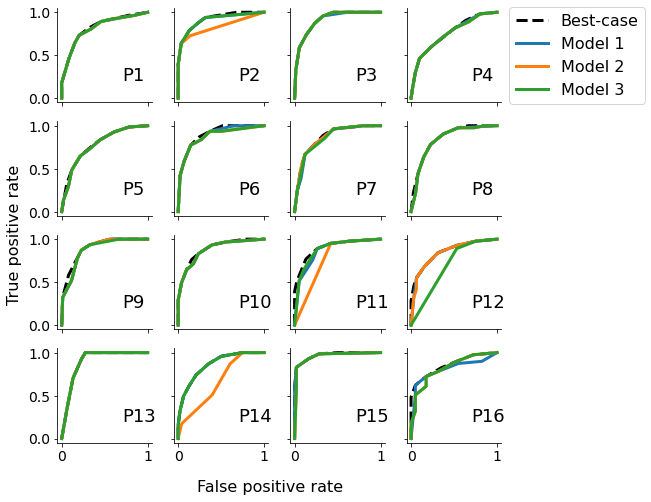

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(8,8), sharex=True, sharey=True)

fig.text(0.37, 0.04, "False positive rate", fontsize=16)
fig.text(0.04, 0.37, "True positive rate", fontsize=16, rotation=90)

auc_diffs = []

for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
    ax.set_aspect("equal")

    best_case_roc, best_case_auc = get_roc_curve(data_means, exp_measures, subj_id, model_no="best_case")
    ax.plot(best_case_roc[0], best_case_roc[1], label="Best-case", ls="--", color="black", lw=3)

    subj_auc_diffs = []
    for model_no in [1, 2, 3]:
        model_roc, model_auc = get_roc_curve(data_means, exp_measures, subj_id, model_no=model_no)
        ax.plot(model_roc[0], model_roc[1], label="Model %i" % model_no, lw=3)
        subj_auc_diffs.append(best_case_auc - model_auc)

    auc_diffs.append(subj_auc_diffs)

    ax.text(0.7, 0.2, "P%i" % (subj_idx+1), fontsize=18)
    if subj_idx == 3:
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

auc_diffs = pd.DataFrame(auc_diffs, index=subjects, columns=["Model %i" % (i+1) for i in range(3)])

For all three models, the difference between best-case ROC and the model ROC is small. This can also be seen in the difference between AUCs

Text(0, 0.5, 'Best-case AUC - model AUC')

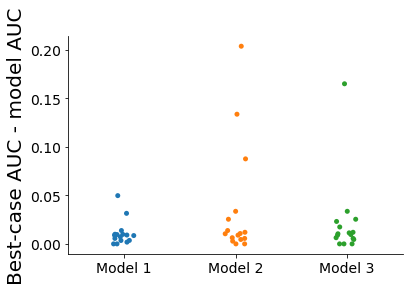

In [29]:
ax = sns.stripplot(data=auc_diffs)
ax.set_ylabel("Best-case AUC - model AUC")

### Pseudo-$R^2$

In [73]:
def plot_rt_r_squared(data_means, model_no=1):
    fig, axes = plt.subplots(4, 4, figsize=(8,8), sharex=False, sharey=False)

    # fig.text(0.37, 0.04, "RT data", fontsize=16)
    # fig.text(0.04, 0.37, "RT model", fontsize=16, rotation=90)

    data_vs_model = get_data_vs_model_means(data_means=data_means, model_no=model_no, kind="full_data")
    r_squared = []
    for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
        subj_data_vs_model = data_vs_model[data_vs_model.subj_id==subj_id]
        g = sns.scatterplot(ax=ax, data=subj_data_vs_model, x="RT_data", y="RT_model", hue="condition", legend=False, s=200)

        control_x = np.linspace(subj_data_vs_model.RT_data.min()-0.05, subj_data_vs_model.RT_data.max()+0.05, 2)
        ax.plot(control_x, control_x, color="grey")
        ax.set_aspect("equal")
        ax.set_xlabel("")
        ax.set_ylabel("")
        fit_metric = (1 - ((subj_data_vs_model["RT_model"]-subj_data_vs_model["RT_data"]).pow(2).sum())
                  /(subj_data_vs_model["RT_data"]-subj_data_vs_model["RT_data"].mean()).pow(2).sum())
        ax.set_title("P%i, $R^2$=%.2f" % (subj_idx+1, fit_metric), fontsize=16)
        r_squared.append(fit_metric)
        # ax.text(0.7, 0.4, )
    fig.suptitle("Model %i" % model_no, fontsize=24)
    plt.tight_layout()

    return r_squared

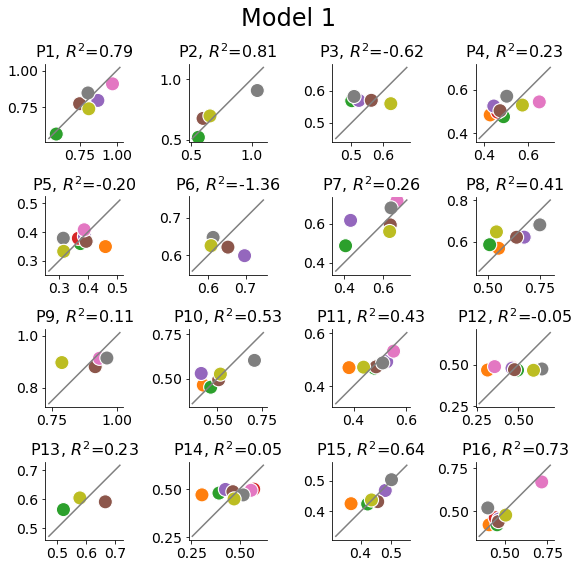

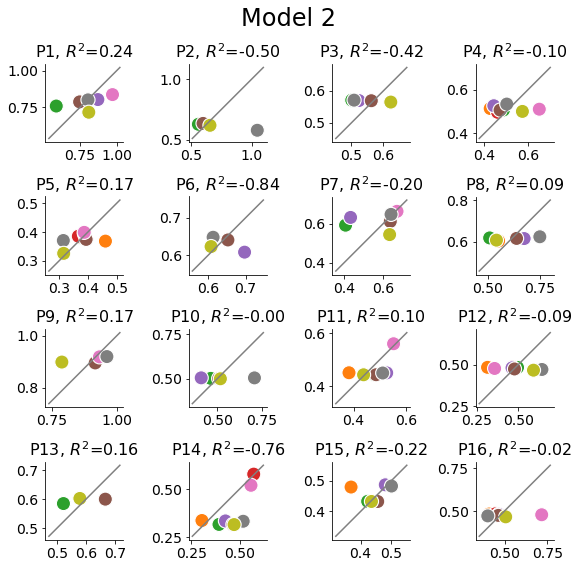

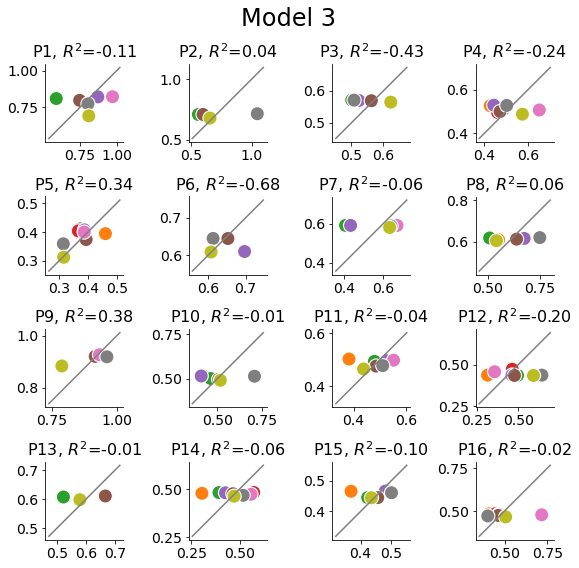

In [80]:
r_squared = pd.DataFrame([plot_rt_r_squared(data_means, model_no=model_no) for model_no in [1, 2, 3]]).T

<AxesSubplot:>

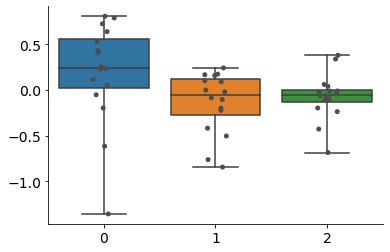

In [82]:
sns.stripplot(data=r_squared, color=".3")
sns.boxplot(data=r_squared, whis=np.inf)

In [37]:
def plot_data_vs_model(var, data_vs_model, model_no):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)
    ax.axes.set_aspect("equal")
    g = sns.scatterplot(ax=ax, data=data_vs_model, x="%s_data" % var, y="%s_model" % var,
                        hue="subj_id", style="condition", legend="full", palette="tab20")
    g.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=2)
    control_x = np.linspace(data_vs_model.RT_data.min()-0.05, data_vs_model.RT_data.max()+0.05, 2) \
        if var=="RT" else np.linspace(0,1,2)
    ax.plot(control_x, control_x, color="grey")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    fit_metric = (1 - ((data_vs_model["%s_model" % var]-data_vs_model["%s_data" % var]).pow(2).sum())
                  /(data_vs_model["%s_data" % var]-data_vs_model["%s_data" % var].mean()).pow(2).sum())

    fig.suptitle(r"Model %i: pseudo-$R^2=%.2f$" % (model_no, fit_metric))
    fig.savefig("../output/%s_%i.png" % (var, model_no), bbox_inches="tight")

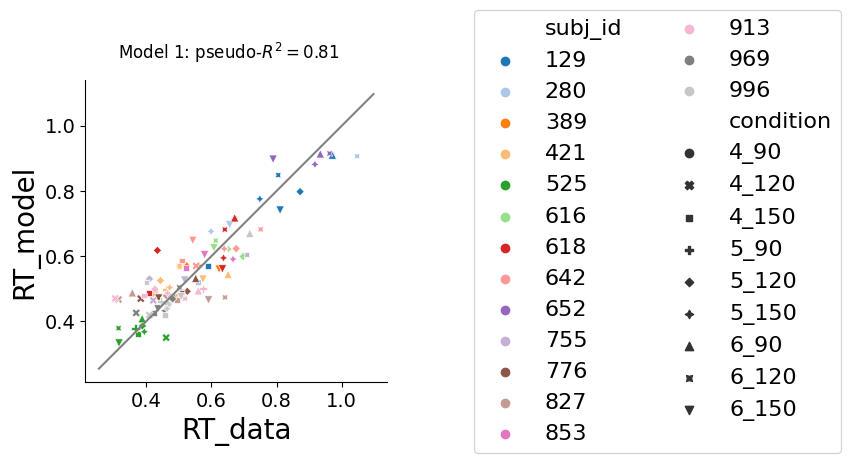

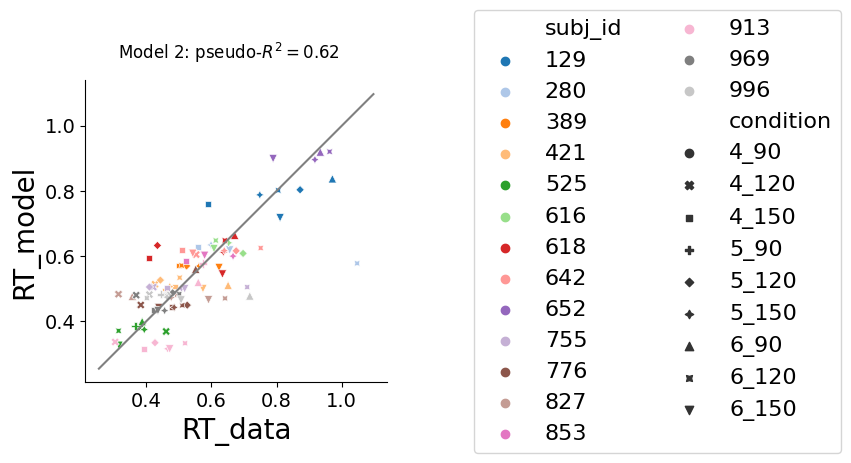

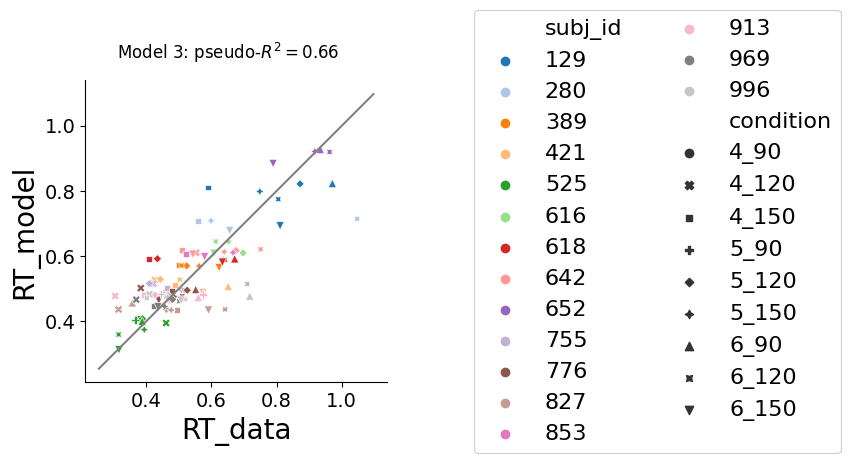

In [31]:
for model_no in [1,2,3]:
    data_vs_model = get_data_vs_model_means(data_means=data_means, model_no=model_no, kind="full_data")
    # plot_data_vs_model("p_go", data_vs_model, model_no=model_no)
    plot_data_vs_model("RT", data_vs_model, model_no=model_no)

## p_go and RT figures per participant for three models

In [ ]:
for model_no in [1,2,3]:
    model_measures_all_conditions = pd.read_csv(os.path.join(fit_results_path % model_no, "full_data_measures.csv"))

    plot_compare_model_exp("is_go_decision", exp_measures, model_measures_all_conditions, "Probability of go")
    plt.savefig("../output/fig_p_go_model_%i.png" % model_no, bbox_inches="tight")

    plot_compare_model_exp("RT", exp_measures, model_measures_all_conditions, "Response time, s")
    plt.savefig("../output/fig_RT_model_%i.png" % model_no, bbox_inches="tight")

## Full RT distributions

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)
for model_no in [1, 2, 3]:
    model_rts = pd.read_csv(os.path.join(fit_results_path % model_no, "full_data_rt_cdf.csv"))
    plot_vincentized_dist(fig, axes, exp_measures, model_rts, model_no)
    # fig.suptitle("Model %i" % model_no)
    plt.savefig("../output/fig_RT_dist_all_models.png", bbox_inches="tight")

- ROC and R^2 for individual participants for three models
- ROC and R^2 for cross-validation on vincentized data for three models